# Project 3

## Code

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

# Create the scenario graph
def create_grid_graph(rows, cols, reward):
  graph = nx.Graph()
  for i in range(1, rows + 1):
    for j in range(1, cols + 1):
      node = (i, j)
      graph.add_node(node, value=0, traversable=True, exit=False, reward=reward, direction='')
      if i > 1:
        graph.add_edge(node, (i - 1, j))
      if i < rows:
        graph.add_edge(node, (i + 1, j))
      if j > 1:
        graph.add_edge(node, (i, j - 1))
      if j < cols:
        graph.add_edge(node, (i, j + 1))

  return graph

# Conduct the bellman update
def bellman_update(graph, discount_factor=0.99, noise=0.1):
  new_values = {}

  for node in graph.nodes():
    if not graph.nodes[node]['traversable']:
      continue
    if graph.nodes[node]['exit']:
      continue

    adjacency_list = list(graph.neighbors(node))

    row, col = node
    possible_actions = [
        (row + 1, col),  # Up
         (row, col + 1),  # Right
        (row - 1, col),  # Down
        (row, col - 1)  # Left
    ]

    # Fix the possible movement based on out of bound or obstacle condition
    rectified_actions = []
    for action in possible_actions:
      if action not in adjacency_list or not graph.nodes[action]['traversable']:
        rectified_actions.append(node)
      else:
        rectified_actions.append(action)

    possible_actions = rectified_actions

    up = ( (1-noise) * graph.nodes[possible_actions[0]]['value'] + (noise/2 * graph.nodes[possible_actions[1]]['value']) + (noise/2 * graph.nodes[possible_actions[3]]['value']) )
    right = ( (1-noise) * graph.nodes[possible_actions[1]]['value'] + (noise/2 * graph.nodes[possible_actions[0]]['value']) + (noise/2 * graph.nodes[possible_actions[2]]['value']) )
    down = ( (1-noise) * graph.nodes[possible_actions[2]]['value'] + (noise/2 * graph.nodes[possible_actions[1]]['value']) + (noise/2 * graph.nodes[possible_actions[3]]['value']) )
    left = ( (1-noise) * graph.nodes[possible_actions[3]]['value'] + (noise/2 * graph.nodes[possible_actions[2]]['value']) + (noise/2 * graph.nodes[possible_actions[0]]['value']) )

    idx = np.argmax([up, right, down, left])
    direction = ['up', 'right', 'down', 'left']
    graph.nodes[node]['value'] = graph.nodes[node]['reward'] + discount_factor * max(up, right, down, left)
    graph.nodes[node]['direction'] = direction[idx]

  return graph

# Traverse the graph
def follow_path(graph, start_node):
  current_node = start_node
  path = [current_node]
  sum_reward = 0

  while not graph.nodes[current_node]['exit']:
    direction = graph.nodes[current_node]['direction']
    row, col = current_node

    if direction == 'up':
      next_node = (row + 1, col)
    elif direction == 'right':
      next_node = (row, col + 1)
    elif direction == 'down':
      next_node = (row - 1, col)
    elif direction == 'left':
      next_node = (row, col - 1)
    else:
      break

    # Check if the next node is traversable
    if next_node in graph.neighbors(current_node) and graph.nodes[next_node]['traversable']:
      current_node = next_node
      path.append(current_node)
      sum_reward += graph.nodes[current_node]['value']
    else:
      break

  return path, sum_reward

## R1

Live in reward -0.3
Total reward: 537.31
Live in reward -0.25
Total reward: 544.19
Live in reward -0.2
Total reward: 551.07
Live in reward -0.15000000000000002
Total reward: 557.95
Live in reward -0.10000000000000003
Total reward: 564.83

Best live-in reward (r): -0.10000000000000003
Total reward for P1: 564.83


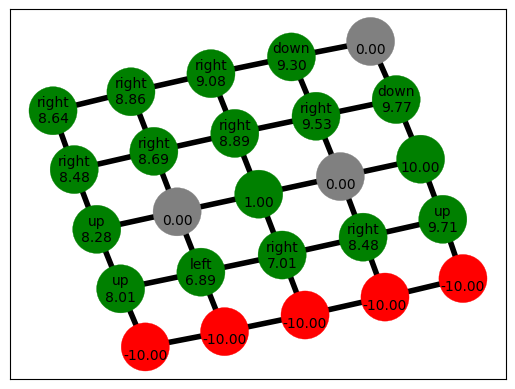

In [ ]:
best_reward = -float('inf')
best_policy_graph = None
best_r = None

for reward in np.arange(-0.3,-0.06,0.05):
  G = create_grid_graph(5, 5, reward)

  # Set pitfall
  for x in range(1, 6):
    G.nodes[(1, x)]['value'] = -10
    G.nodes[(1, x)]['exit'] = True
    G.nodes[(1, x)]['reward'] = 0

  # Set obstacle
  G.nodes[(3, 2)]['traversable'] = False
  G.nodes[(3, 2)]['reward'] = 0
  G.nodes[(3, 4)]['traversable'] = False
  G.nodes[(3, 4)]['reward'] = 0
  G.nodes[(5, 5)]['traversable'] = False
  G.nodes[(5, 5)]['reward'] = 0

  # Set Goal nodes
  G.nodes[(3, 3)]['value'] = 1
  G.nodes[(3, 3)]['exit'] = True
  G.nodes[(3, 3)]['reward'] = 0

  G.nodes[(3, 5)]['value'] = 10
  G.nodes[(3, 5)]['exit'] = True
  G.nodes[(3, 5)]['reward'] = 0

  # Perform Bellman updates for a certain number of iterations
  for _ in range(500):
    G = bellman_update(G)

  print(f'Live in reward {reward}')

  # Policy path
  paths = [node for node in G.nodes() if G.nodes[node]['traversable'] and not G.nodes[node]['exit']]

  total_reward = 0
  for start_node in paths:
    path = follow_path(G, start_node)
    total_reward += path[1]
  print(f"Total reward: {total_reward:.2f}", )

  if total_reward > best_reward:
    best_reward = total_reward
    best_policy_graph = G.copy()
    best_r = reward

G = best_policy_graph
print(f"\nBest live-in reward (r): {best_r}")
print(f"Total reward for P1: {best_reward:.2f}")

links = [(u, v) for (u, v, d) in G.edges(data=True)]
pos = nx.nx_pydot.graphviz_layout(G)

node_colors = []
for node in G.nodes:
  if not G.nodes[node]['traversable']:
    node_colors.append('gray')
  elif G.nodes[node]['value'] < 0:
    node_colors.append('red')
  elif G.nodes[node]['value'] >= 1:
    node_colors.append('green')
  else:
    node_colors.append('lightblue')

nx.draw_networkx_nodes(G, pos, node_size=1200, node_color=node_colors, linewidths=0.25)  # draw nodes
nx.draw_networkx_edges(G, pos, edgelist=links, width=4)  # draw edges

# node labels (location and value)
node_labels = {node: f"{G.nodes[node]['direction']}\n{G.nodes[node]['value']:.2f}" for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_family="sans-serif")

plt.show()

## R2

Live in reward -0.3
Total reward: 586.38
Live in reward -0.25
Total reward: 594.99
Live in reward -0.2
Total reward: 654.14
Live in reward -0.15000000000000002
Total reward: 664.91
Live in reward -0.10000000000000003
Total reward: 675.67

Best live-in reward (r): -0.10000000000000003
Total reward for P1: 675.67


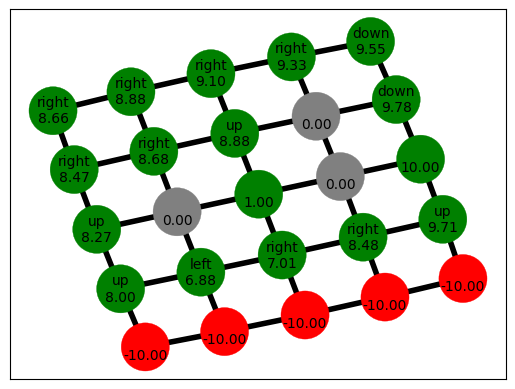

In [ ]:
best_reward = -float('inf')
best_policy_graph = None
best_r = None

for reward in np.arange(-0.3,-0.06,0.05):
  G = create_grid_graph(5, 5, reward)

  # Set pitfall
  for x in range(1, 6):
    G.nodes[(1, x)]['value'] = -10
    G.nodes[(1, x)]['exit'] = True
    G.nodes[(1, x)]['reward'] = 0

  # Set obstacle
  G.nodes[(3, 2)]['traversable'] = False
  G.nodes[(3, 2)]['reward'] = 0
  G.nodes[(3, 4)]['traversable'] = False
  G.nodes[(3, 4)]['reward'] = 0
  G.nodes[(4, 4)]['traversable'] = False
  G.nodes[(4, 4)]['reward'] = 0

  # Set Goal nodes
  G.nodes[(3, 3)]['value'] = 1
  G.nodes[(3, 3)]['exit'] = True
  G.nodes[(3, 3)]['reward'] = 0

  G.nodes[(3, 5)]['value'] = 10
  G.nodes[(3, 5)]['exit'] = True
  G.nodes[(3, 5)]['reward'] = 0

  # Perform Bellman updates for a certain number of iterations
  for _ in range(500):
    G = bellman_update(G)

  print(f'Live in reward {reward}')

  # Policy path
  paths = [node for node in G.nodes() if G.nodes[node]['traversable'] and not G.nodes[node]['exit']]

  total_reward = 0
  for start_node in paths:
    path = follow_path(G, start_node)
    total_reward += path[1]
  print(f"Total reward: {total_reward:.2f}", )

  if total_reward > best_reward:
    best_reward = total_reward
    best_policy_graph = G.copy()
    best_r = reward

G = best_policy_graph
print(f"\nBest live-in reward (r): {best_r}")
print(f"Total reward for P1: {best_reward:.2f}")

links = [(u, v) for (u, v, d) in G.edges(data=True)]
pos = nx.nx_pydot.graphviz_layout(G)

node_colors = []
for node in G.nodes:
  if not G.nodes[node]['traversable']:
    node_colors.append('gray')
  elif G.nodes[node]['value'] < 0:
    node_colors.append('red')
  elif G.nodes[node]['value'] >= 1:
    node_colors.append('green')
  else:
    node_colors.append('lightblue')

nx.draw_networkx_nodes(G, pos, node_size=1200, node_color=node_colors, linewidths=0.25)  # draw nodes
nx.draw_networkx_edges(G, pos, edgelist=links, width=4)  # draw edges

# node labels (location and value)
node_labels = {node: f"{G.nodes[node]['direction']}\n{G.nodes[node]['value']:.2f}" for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_family="sans-serif")

plt.show()